<a href="https://colab.research.google.com/github/BrunoMoss/BI-Master/blob/main/Trabalho_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalação de bibliotecas

In [1]:
!pip install deap
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 17.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 111.7 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15636 sha256=f3d285135717c64c4a4d45cf1e3c01ddaec67790be69396037675edd11561600
  Stored in directory: /root/.cache/pip/wheels/cc/bd/6f/664d62c99327abeef7d86489e6631cbf45b56fbf7ef1d6ef00
  Created wheel for peewee: filename=peewee-3.18.2-cp312-cp312-linux_x86_64.whl size=936667 sha256=aa3f4dadbe93b7bffaaa474e74c4e7e7e3553fe30b

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import qmc
import random
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from deap import cma
import math
import requests
import json
import warnings
import time
import itertools
plt.style.use("dark_background")
warnings.filterwarnings(action='once')

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Carregamento de dados

In [3]:
# Parâmetros de dados
DATA_PARAMS = {
    'start_date': '2024-05-01',
    'end_date': '2025-05-01',
    'test_start_date': '2024-05-01',
    'test_end_date': '2025-05-01',
    'benchmark': '^OEX',
}

# URLs de APIs
API_ENDPOINTS = {
    'etf_central': "https://www.etfcentral.com/search-api/search_v2/_/ju=232/nyseTicker,label,exposure_description,nyseTraded,usd_flow1m,usd_perf1m,shareVol1m,usd_aum,expense_ratio,ttmDividendYield/default/0/100"
}


In [4]:
"""
## 1. Funções para Carregamento e Processamento de Dados
"""

def fetch_etf_data(url, max_retries=3):
    """
    Obtém dados de ETFs com tratamento de erros.

    Args:
        url (str): URL da API para obter dados de ETFs.
        max_retries (int): Número máximo de tentativas em caso de falha.

    Returns:
        list: Lista de tickers de ETFs.
    """
    for attempt in range(max_retries):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()  # Levanta exceção para códigos de erro HTTP
            data = json.loads(response.text)
            return [item['nyseTicker'] for item in data['results']['docs']]
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                wait_time = 2 ** attempt  # Backoff exponencial
                print(f"Tentativa {attempt+1} falhou. Tentando novamente em {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"Falha ao obter dados após {max_retries} tentativas: {e}")
                raise

def download_price_data(tickers, start_date, end_date, column='Close'):
    """
    Baixa dados históricos de preços.

    Args:
        tickers (list): Lista de tickers para download.
        start_date (str): Data de início no formato 'YYYY-MM-DD'.
        end_date (str): Data de fim no formato 'YYYY-MM-DD'.
        column (str): Coluna de preço a ser extraída (default: 'Close').

    Returns:
        pandas.DataFrame: DataFrame com preços históricos.
    """
    try:
        import yfinance as yf
        print(f"Baixando dados para {len(tickers)} tickers de {start_date} a {end_date}")
        df = yf.download(tickers, start=start_date, end=end_date)[column]

        # Registra informações sobre valores ausentes
        missing_values = df.isna().sum()
        if missing_values.sum() > 0:
            print(f"Valores ausentes nos dados: {missing_values[missing_values > 0]}")

        return df
    except Exception as e:
        print(f"Erro ao baixar dados: {e}")
        raise

def preprocess_price_data(df):
    """
    Pré-processa dados de preços, tratando valores ausentes e calculando retornos.

    Estratégia:
    1. Preenche valores ausentes com o último valor válido (backward fill)
    2. Calcula retornos percentuais diários
    3. Remove a primeira linha (que será NaN após o cálculo de retornos)

    Args:
        df (pandas.DataFrame): DataFrame com preços de fechamento.

    Returns:
        pandas.DataFrame: DataFrame com retornos diários.
    """
    # Copia para evitar modificar o original
    df_processed = df.copy()

    # Documenta a quantidade de valores ausentes antes do tratamento
    missing_values = df_processed.isna().sum()
    if missing_values.sum() > 0:
        print(f"Valores ausentes antes do tratamento: {missing_values}")

    # Preenche valores ausentes
    df_processed.bfill(inplace=True)

    # Calcula retornos
    df_returns = df_processed.pct_change().dropna()

    return df_returns

In [5]:
# Acessa os 100 mais negociados ETF's no mercado americano

print("Obtendo lista de ETFs...")
tickers = fetch_etf_data(API_ENDPOINTS['etf_central'])
print(f"Obtidos {len(tickers)} tickers de ETFs")

# Seleciona os 50 primeiros
tickers = tickers[:50]

Obtendo lista de ETFs...
Obtidos 100 tickers de ETFs


In [ ]:
# prompt: salvar a lista tickers em um csv no meu  drive
#from google.colab import drive
#drive.mount('/content/drive')

# Carrega uma lista pré-salva
#file_path = '/content/drive/My Drive/tickers_20250201_040506.csv'
#tickers = pd.read_csv(file_path)['Tickers'].values.tolist()


# Salva a lista de tickers em um arquivo CSV no Google Drive
#file_path = f'/content/drive/My Drive/tickers_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'  # Substitua pelo caminho desejado no seu Google Drive
#pd.DataFrame({'Tickers': tickers}).to_csv(file_path, index=False)

Mounted at /content/drive


## Estudo de caso

In [6]:
# Baixa dados históricos
try:
    print(f"Baixando dados históricos de {DATA_PARAMS['start_date']} a {DATA_PARAMS['end_date']}...")
    df = download_price_data(
        tickers,
        DATA_PARAMS['start_date'],
        DATA_PARAMS['end_date']
    )

    # Baixa benchmark
    benchmark_df = download_price_data(
        DATA_PARAMS['benchmark'],
        DATA_PARAMS['start_date'],
        DATA_PARAMS['end_date']
    )

    # Pré-processa dados
    df_returns = preprocess_price_data(df)
    benchmark_returns = preprocess_price_data(benchmark_df).iloc[:, 0]

    print(f"Dados processados: {df_returns.shape[0]} observações, {df_returns.shape[1]} ativos")
except Exception as e:
    print(f"Erro ao baixar dados: {e}")
    raise

Baixando dados históricos de 2024-05-01 a 2025-05-01...
Baixando dados para 50 tickers de 2024-05-01 a 2025-05-01


/tmp/ipython-input-2915766330.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start_date, end=end_date)[column]
[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7b2a7ac69d30>
[**                     4%                       ]  2 of 50 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcn

Baixando dados para 4 tickers de 2024-05-01 a 2025-05-01


[*********************100%***********************]  1 of 1 completed

Dados processados: 249 observações, 50 ativos


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Classe com otimizador

In [30]:
"""
## 2. Implementação da Classe Base para Otimizadores
"""

class BaseOptimizer:
    """
    Classe base para otimizadores de portfólio.

    Esta classe implementa funcionalidades comuns a todos os otimizadores,
    como cálculo de volatilidade, VaR e restrições.
    """

    def __init__(self, alpha, days, lbda, nr_assets, vl_var_min, vl_var_max, min_weight):
        """
        Inicializa uma instância da classe BaseOptimizer.

        Args:
            alpha (float): Nível de significância do VaR paramétrico (0-1)
            days (int): Base de cálculo das medidas
            lbda (float): Lambda, fator de decaimento para EWMA (0-1)
            nr_assets (int): Número de ativos no portfólio
            vl_var_min (float): VaR mínimo do portfólio
            vl_var_max (float): VaR máximo do portfólio
            min_weight (float): Peso mínimo dos ativos no portfólio
        """
        # Validação de parâmetros
        if not 0 < alpha < 1:
            raise ValueError("Alpha deve estar entre 0 e 1")
        if days <= 0:
            raise ValueError("Days deve ser positivo")
        if not 0 < lbda < 1:
            raise ValueError("Lambda deve estar entre 0 e 1")
        if nr_assets <= 0:
            raise ValueError("Número de ativos deve ser positivo")
        if vl_var_min >= vl_var_max:
            raise ValueError("VaR mínimo deve ser menor que VaR máximo")
        if min_weight <= 0:
            raise ValueError("Peso mínimo deve ser positivo")

        self.alpha = alpha
        self.days = days
        self.lbda = lbda
        self.nr_assets = nr_assets
        self.vl_var_min = vl_var_min
        self.vl_var_max = vl_var_max
        self.min_weight = min_weight
        self.df_rets = None

        # Cache para cálculos
        self._last_df_rets = None
        self._last_cov = None
        self._last_df_rets_id = None


        print(f"Inicializado otimizador com alpha={alpha}, days={days}, lambda={lbda}, "
                   f"nr_assets={nr_assets}, var_min={vl_var_min}, var_max={vl_var_max}, "
                   f"min_weight={min_weight}")

    def set_returns(self, df_rets):
        """
        Define os retornos a serem utilizados na otimização.

        Args:
            df_rets (pandas.DataFrame): DataFrame com retornos diários
        """
        self.df_rets = df_rets
        # Limpa o cache quando novos retornos são definidos
        self._last_df_rets = None
        self._last_cov = None

        print(f"Definidos retornos com {df_rets.shape[0]} observações e {df_rets.shape[1]} ativos")

    def _ewma_volatility(self, rets):
        """
        Atualiza a matriz de covariância EWMA de forma recursiva.
        """
        n_assets = rets.shape[1]
        ewma_cov = np.outer(rets[0], rets[0])  # Inicialização

        for t in range(1, len(rets)):
            ret = rets[t]
            ewma_cov = (self.lbda* ewma_cov +
                        (1 - self.lbda) * np.outer(ret, ret))

        return ewma_cov

    def _compute_standard_covariance(self, returns):
        """Calcula matriz de covariância amostral padrão"""
        return np.cov(returns, rowvar=False, bias=True)  # bias=True para população

    def calc_port_vol(self, df_rets, weights, days, ewma=True):
        """
        Calcula a volatilidade EWMA do portfólio.

        Args:
            returns_df (pd.DataFrame): DataFrame de retornos diários (cada coluna = um ativo).
            weights (np.array): Vetor de pesos do portfólio (deve somar ~1).
            annualize_days (int, optional): Número de dias para anualização (ex: 252 para anualizar).

        Returns:
            float: Volatilidade do portfólio (anualizada se annualize_days for fornecido).
        """
        returns = df_rets.values
        weights = np.asarray(weights)

        # Verifica se os pesos são válidos
        #if not np.isclose(np.sum(weights), 1, rtol=0.01):
            #raise ValueError("Os pesos do portfólio devem somar aproximadamente 1.")

        # Recalcula a matriz de covariância apenas se os retornos mudaram (caching implícito)
        df_id = id(df_rets)
        if df_id != self._last_df_rets_id or self._last_cov is None:
            if ewma:
                self._last_cov = self._ewma_volatility(returns)
            else:
                self._last_cov = self._compute_standard_covariance(returns)
            self._last_df_rets_id = df_id

        # Cálculo da variância do portfólio: w^T @ Σ @ w
        portfolio_variance = weights.T @ self._last_cov @ weights
        portfolio_volatility = np.sqrt(portfolio_variance)

        # Anualização (opcional)
        if days is not None:
            portfolio_volatility *= np.sqrt(days)

        return portfolio_volatility

    def calc_portfolio_perf_VaR(self, weights, df_rets, days):
        """
        Calcula o retorno, volatilidade e VaR de um portfólio.

        Args:
            weights (numpy.ndarray): Pesos dos ativos no portfólio
            df_rets (pandas.DataFrame): Retornos diários dos ativos
            days (int): Base de cálculo das medidas

        Returns:
            tuple: (retorno do portfólio, volatilidade do portfólio, VaR do portfólio)
        """
        weights = np.array(weights)
        mean_returns = df_rets.mean()
        portfolio_return = np.sum(mean_returns * weights) * days
        portfolio_vol = self.calc_port_vol(df_rets, weights, days)
        portfolio_var = abs(portfolio_return - (portfolio_vol * norm.ppf(1 - self.alpha)))
        return portfolio_return, portfolio_vol, portfolio_var

    def _count_not_equal_zero(self, arr):
        """
        Conta quantos elementos do array são diferentes de zero.

        Args:
            arr (numpy.ndarray): Array de pesos

        Returns:
            int: Número de elementos diferentes de zero
        """
        # Arredonda cada elemento do array para a quarta casa decimal
        rounded_arr = [round(num, 4) for num in arr]

        # Conta quantos elementos arredondados são iguais a zero
        zero_count = sum(1 for num in rounded_arr if num == 0)

        # Retorna número de items diferente de zero
        return len(arr) - zero_count

    def _count_items_in_range(self, array, k):
        """
        Conta quantos elementos do array estão no intervalo (0, k).

        Args:
            array (numpy.ndarray): Array de pesos
            k (float): Limite superior do intervalo

        Returns:
            int: Número de elementos no intervalo (0, k)
        """
        return sum(1 for item in array if 0 < item < k)

    def _penalize_var(self, x, lower_bound, upper_bound):
        """
        Calcula a penalidade para o VaR fora do intervalo.

        Args:
            x (float): Valor do VaR
            lower_bound (float): Limite inferior
            upper_bound (float): Limite superior

        Returns:
            float: Valor da penalidade
        """
        if x < lower_bound:
            return lower_bound - x
        elif x > upper_bound:
            return x - upper_bound
        else:
            return 0

    def _feasible(self, weights):
        """
        Verifica se os pesos atendem às restrições.

        Args:
            weights (numpy.ndarray): Pesos dos ativos

        Returns:
            bool: True se os pesos atendem às restrições, False caso contrário
        """
        weights = np.array(weights)
        weights = weights / np.sum(weights)
        var = self.calc_portfolio_perf_VaR(weights, self.df_rets, self.days)[2]

        # Verifica número de ativos
        assets_ok = self._count_not_equal_zero(weights) == self.nr_assets

        # Verifica pesos mínimos
        weights_ok = self._count_items_in_range(weights, self.min_weight) == 0

        # Verifica VaR
        var_ok = self.vl_var_min < var < self.vl_var_max

        return assets_ok and weights_ok and var_ok

    def _apply_penalty(self, weights, penalty_factor=10):
        """
        Aplica penalidades para restrições violadas.

        Args:
            weights (numpy.ndarray): Pesos dos ativos
            penalty_factor (float): Fator de penalização

        Returns:
            float: Valor da penalidade
        """
        weights = np.array(weights)
        weights = weights / np.sum(weights)

        # Penalidade para número de ativos
        assets_count = self._count_not_equal_zero(weights)
        penalty_assets = abs(assets_count - self.nr_assets)

        # Penalidade para pesos mínimos
        penalty_weights = self._count_items_in_range(weights, self.min_weight)

        # Penalidade para VaR
        var = self.calc_portfolio_perf_VaR(weights, self.df_rets, self.days)[2]
        penalty_var = self._penalize_var(var, self.vl_var_min, self.vl_var_max)

        # Calcula penalidade total
        total_penalty = (penalty_weights + penalty_assets + penalty_var) * penalty_factor

        return total_penalty

    def optimize(self):
        """
        Método abstrato para otimização.
        Deve ser implementado pelas classes derivadas.

        Returns:
            numpy.ndarray: Pesos otimizados dos ativos
        """
        raise NotImplementedError("Método deve ser implementado pela classe derivada")

In [31]:
class GeneticOptimizer(BaseOptimizer):
    """
    Otimizador de portfólio usando algoritmo genético.

    Esta classe implementa a otimização de portfólio usando o algoritmo
    genético da biblioteca DEAP.
    """

    def __init__(self, alpha, days, lbda, nr_assets, vl_var_min, vl_var_max, min_weight):
        """
        Inicializa o otimizador genético.

        Args:
            alpha (float): Nível de significância do VaR paramétrico
            days (int): Base de cálculo das medidas
            lbda (float): Lambda, fator de decaimento para EWMA
            nr_assets (int): Número de ativos no portfólio
            vl_var_min (float): VaR mínimo do portfólio
            vl_var_max (float): VaR máximo do portfólio
            min_weight (float): Peso mínimo dos ativos no portfólio
        """
        super().__init__(alpha, days, lbda, nr_assets, vl_var_min, vl_var_max, min_weight)

        # Importa DEAP
        from deap import base, creator, tools

        # Limpa definições anteriores do DEAP, se existirem
        if 'FitnessMax' in creator.__dict__:
            del creator.FitnessMax
        if 'Individual' in creator.__dict__:
            del creator.Individual

        # Configuração do DEAP
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        self.toolbox = base.Toolbox()

        print("Inicializado otimizador genético")

    def _evaluate_function(self, individual):
        """
        Função de avaliação para o algoritmo genético.

        Args:
            individual (list): Indivíduo (pesos não normalizados)

        Returns:
            tuple: Tupla com o retorno do portfólio
        """
        weights = np.array(individual)
        weights = weights / np.sum(weights)
        ret = self.calc_portfolio_perf_VaR(weights, self.df_rets, self.days)[0]
        return (ret,)

    def _create_individuals(self, icls, random_function):
        """
        Função para criar indivíduos.

        Args:
            icls (class): Classe do indivíduo
            random_function (function): Função para gerar números aleatórios

        Returns:
            Individual: Indivíduo criado
        """
        cromossomo = [random_function() for _ in range(len(self.df_rets.columns))]
        return icls(cromossomo)

    def _create_individuals_lhs(self):
        """
        Função para criar indivíduos.

        Args:
            icls (class): Classe do indivíduo
            random_function (function): Função para gerar números aleatórios

        Returns:
            Individual: Indivíduo criado
        """
        ativos_selecionados = np.random.choice(len(self.df_rets.columns), self.nr_assets, replace=False)
        sampler = qmc.LatinHypercube(d=self.nr_assets)
        amostras = sampler.random()[0]
        pesos = amostras/np.sum(amostras)
        cromossomo = np.zeros(len(self.df_rets.columns))
        cromossomo[ativos_selecionados] = pesos
        return cromossomo

    def optimize(self, population_size=2000, generations=30,
                crossover_prob=0.85, mutation_prob=0.5,
                tournament_size=10, indpb=0.3, verbose=True):
        """
        Executa a otimização genética.

        Args:
            population_size (int): Tamanho da população
            generations (int): Número de gerações
            crossover_prob (float): Probabilidade de cruzamento
            mutation_prob (float): Probabilidade de mutação
            tournament_size (int): Tamanho do torneio para seleção
            indpb (float): Probabilidade de um gene sofrer mutação
            verbose (bool): Se True, exibe progresso

        Returns:
            numpy.ndarray: Pesos otimizados dos ativos
        """
        from deap import algorithms, tools,creator

        if self.df_rets is None:
            raise ValueError("Retornos não definidos. Use set_returns() antes de otimizar.")

        print(f"Iniciando otimização genética com população={population_size}, gerações={generations}")

        # Registro de funções no toolbox
        #self.toolbox.register("random_int", random.randint, 0, 1000000)
        #self.toolbox.register("individual", self._create_individuals, creator.Individual, self.toolbox.random_int)
        self.toolbox.register("individual", tools.initIterate, creator.Individual, self._create_individuals_lhs)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("evaluate", self._evaluate_function)
        self.toolbox.decorate("evaluate", tools.DeltaPenalty(self._feasible, 0, self._apply_penalty))
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutFlipBit, indpb=indpb)
        self.toolbox.register("select", tools.selTournament, tournsize=tournament_size)

        # Inicialização da população
        pop = self.toolbox.population(n=population_size)
        hof = tools.HallOfFame(1)

        # Estatísticas
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        # Execução do algoritmo
        pop, log = algorithms.eaSimple(
            pop, self.toolbox,
            cxpb=crossover_prob,
            mutpb=mutation_prob,
            ngen=generations,
            stats=stats,
            halloffame=hof,
            verbose=verbose
        )

        # Normaliza os pesos do melhor indivíduo
        best_weights = np.array(hof[0])
        best_weights = best_weights / np.sum(best_weights)

        print(f"Otimização concluída. Melhor fitness: {hof[0].fitness.values[0]}")

        return best_weights

In [32]:
"""
## 6. Implementação do Otimizador Differential Evolution
"""

class DEOptimizer(BaseOptimizer):
    """
    Otimizador de portfólio usando Differential Evolution.

    Esta classe implementa a otimização de portfólio usando o algoritmo
    Differential Evolution da biblioteca SciPy.
    """

    def __init__(self, alpha, days, lbda, nr_assets, vl_var_min, vl_var_max, min_weight):
        """
        Inicializa o otimizador Differential Evolution.

        Args:
            alpha (float): Nível de significância do VaR paramétrico
            days (int): Base de cálculo das medidas
            lbda (float): Lambda, fator de decaimento para EWMA
            nr_assets (int): Número de ativos no portfólio
            vl_var_min (float): VaR mínimo do portfólio
            vl_var_max (float): VaR máximo do portfólio
            min_weight (float): Peso mínimo dos ativos no portfólio
        """
        super().__init__(alpha, days, lbda, nr_assets, vl_var_min, vl_var_max, min_weight)
        print("Inicializado otimizador Differential Evolution")

    def _objective_function(self, weights):
        """
        Função objetivo para o Differential Evolution (negativa do retorno + penalidades).

        Args:
            weights (numpy.ndarray): Vetor de pesos

        Returns:
            float: Valor da função objetivo
        """
        # Normaliza os pesos
        weights = np.abs(weights)  # Garante que todos os pesos são positivos
        weights = weights / np.sum(weights)

        # Calcula o retorno do portfólio
        ret = self.calc_portfolio_perf_VaR(weights, self.df_rets, self.days)[0]

        # Aplica penalidades
        penalty = self._apply_penalty(weights,1e6)

        # Função objetivo (negativa porque o DE minimiza)
        return -ret + penalty

    def _post_process_solution(self, solution):
        """
        Processa a solução do DE para garantir que atenda às restrições.

        Args:
            solution (numpy.ndarray): Solução encontrada pelo DE

        Returns:
            numpy.ndarray: Solução processada
        """
        # Garante que todos os pesos são positivos
        solution = np.abs(solution)

        # Normaliza os pesos
        solution = solution / np.sum(solution)

        # Ordena os pesos
        sorted_indices = np.argsort(solution)

        # Zera os pesos dos ativos que não estão entre os nr_assets maiores
        for i in sorted_indices[:-self.nr_assets]:
            solution[i] = 0

        # Renormaliza os pesos
        solution = solution / np.sum(solution)

        # Verifica se há pesos abaixo do mínimo e ajusta
        for i in range(len(solution)):
            if 0 < solution[i] < self.min_weight:
                solution[i] = 0

        # Renormaliza novamente
        solution = solution / np.sum(solution)

        return solution

    def optimize(self, population_size=100, max_iter=100, F=0.5, CR=0.7, strategy='best1bin', verbose=True):
        """
        Executa a otimização Differential Evolution.

        Args:
            population_size (int): Tamanho da população
            max_iter (int): Número máximo de iterações
            F (float): Fator de mutação (0-2)
            CR (float): Probabilidade de cruzamento (0-1)
            strategy (str): Estratégia de evolução
            verbose (bool): Se True, exibe progresso

        Returns:
            numpy.ndarray: Pesos otimizados dos ativos
        """
        import scipy.optimize as sco

        if self.df_rets is None:
            raise ValueError("Retornos não definidos. Use set_returns() antes de otimizar.")

        print(f"Iniciando otimização DE com população={population_size}, iterações={max_iter}")

        # Dimensão do problema (número de ativos)
        n_dim = len(self.df_rets.columns)

        # Limites para os pesos (todos positivos)
        bounds = [(0, 1) for _ in range(n_dim)]

        # Callback para exibir progresso
        if verbose:
            def callback(xk, convergence):
                weights = self._post_process_solution(xk)
                ret, vol, var = self.calc_portfolio_perf_VaR(weights, self.df_rets, self.days)
                print(f"Iteração: {callback.count}, Retorno: {ret:.4f}, Vol: {vol:.4f}, VaR: {var:.4f}")
                callback.count += 1
                return False

            callback.count = 0
        else:
            callback = None

        # Executa a otimização
        result = sco.differential_evolution(
            self._objective_function,
            bounds=bounds,
            strategy=strategy,
            maxiter=max_iter,
            popsize=population_size,
            tol=1e-6,
            mutation=F,
            recombination=CR,
            polish=True,
            callback=callback,
            updating='deferred',
            workers=1
        )

        # Processa a solução para garantir que atenda às restrições
        best_weights = self._post_process_solution(result.x)

        # Calcula o retorno, volatilidade e VaR do portfólio otimizado
        ret, vol, var = self.calc_portfolio_perf_VaR(best_weights, self.df_rets, self.days)

        print(f"Otimização concluída. Retorno: {ret:.4f}, Vol: {vol:.4f}, VaR: {var:.4f}")

        return best_weights


### Definição de parâmetros do modelo
O portfolio será criado com base nos dados dos 50 ativos mais negociados.
Ele deverá ter um VaR mínimo de 1.1% e um VaR máximo de 1.2%.
Deverá ser composto por no máximo 5 ativos e cada ativo deverá ter um peso mínimo de 5%.

In [10]:
# Parâmetros de otimização
OPTIMIZATION_PARAMS = {
    'alpha': 0.95,              # Nível de significância do VaR paramétrico
    'days': 1,                  # Base de cálculo das medidas
    'lbda': 0.94,             # Fator de decaimento para EWMA
    'nr_assets': 5,             # Número de ativos no portfólio
    'vl_var_min': 0.016,            # VaR mínimo (1%)
    'vl_var_max': 0.017,           # VaR máximo (1.2%)
    'min_weight': 0.05,         # Peso mínimo dos ativos (5%)
}
Params={'population_size': 500, 'generations': 20, 'crossover_prob': 0.9, 'mutation_prob': 0.3, 'tournament_size': 10, 'indpb': 0.3}
# Parâmetros do algoritmo genético
GENETIC_PARAMS = {
    'population_size': 2000,    # Tamanho da população
    'generations': 30,          # Número de gerações
    'crossover_prob': 0.85,     # Probabilidade de cruzamento
    'mutation_prob': 0.5,       # Probabilidade de mutação
    'tournament_size': 10,      # Tamanho do torneio para seleção
    'indpb': 0.3,               # Probabilidade de um gene sofrer mutação
}
# Parâmetros do Differential Evolution
DE_PARAMS = {
    'population_size': 100,     # Tamanho da população
    'max_iter': 50,            # Número máximo de iterações
    'F': 0.5,                   # Fator de mutação
    'CR': 0.7,                  # Probabilidade de cruzamento
    'strategy': 'best1bin',     # Estratégia de evolução
}
# Inicializa dicionários para armazenar resultados
results = {}
weights = {}
tuning_results = {}
execution_times = {}

In [11]:
# Otimizador Genético
print("Executando otimizador genético")
genetic_optimizer = GeneticOptimizer(
    OPTIMIZATION_PARAMS['alpha'],
    OPTIMIZATION_PARAMS['days'],
    OPTIMIZATION_PARAMS['lbda'],
    OPTIMIZATION_PARAMS['nr_assets'],
    OPTIMIZATION_PARAMS['vl_var_min'],
    OPTIMIZATION_PARAMS['vl_var_max'],
    OPTIMIZATION_PARAMS['min_weight']
)
genetic_optimizer.set_returns(df_returns)

start_time = time.time()
genetic_weights = genetic_optimizer.optimize(**GENETIC_PARAMS)
genetic_time = time.time() - start_time
execution_times['genetic'] = genetic_time

genetic_result = genetic_optimizer.calc_portfolio_perf_VaR(genetic_weights, df_returns, OPTIMIZATION_PARAMS['days'])
genetic_sharpe = genetic_result[0] / genetic_result[1]
results['genetic'] = (*genetic_result, genetic_sharpe)
weights['genetic'] = genetic_weights

print(f"Otimizador genético concluído em {genetic_time:.2f}s. "
               f"Retorno: {genetic_result[0]:.4f}, Vol: {genetic_result[1]:.4f}, "
               f"VaR: {genetic_result[2]:.4f}, Sharpe: {genetic_sharpe:.4f}")


Executando otimizador genético
Inicializado otimizador com alpha=0.95, days=1, lambda=0.94, nr_assets=5, var_min=0.016, var_max=0.017, min_weight=0.05
Inicializado otimizador genético
Definidos retornos com 249 observações e 50 ativos
Iniciando otimização genética com população=2000, gerações=30
gen	nevals	avg     	std    	min     	max        
0  	2000  	-5.29308	6.28286	-30.2792	0.000962105
1  	1838  	-84.3193	89.6865	-490.148	0.000593327
2  	1850  	-84.3934	88.7899	-530.163	0.000618525
3  	1829  	-85.0909	86.7767	-530.126	0.0006708  
4  	1861  	-83.3167	87.6418	-490.155	0.0006708  
5  	1877  	-85.9732	87.3305	-490.134	0.0006708  
6  	1825  	-82.3613	86.9637	-550.137	0.0006708  
7  	1881  	-84.3508	89.336 	-490.143	0.000701246
8  	1853  	-85.2108	88.2525	-510.138	0.000742122
9  	1836  	-84.6382	93.3175	-530.144	0.000801428
10 	1861  	-84.8092	89.2222	-530.142	0.000801428
11 	1847  	-83.0274	89.3255	-510.177	0.000801428
12 	1835  	-81.4148	90.4363	-490.204	0.000801428
13 	1836  	-80.91

In [12]:
print(f"Otimizador genético concluído em {genetic_time:.2f}s. "
               f"Retorno: {genetic_result[0]:.4f}, Vol: {genetic_result[1]:.4f}, "
               f"VaR: {genetic_result[2]:.4f}, Sharpe: {genetic_sharpe:.4f}")


Otimizador genético concluído em 102.84s. Retorno: 0.0010, Vol: 0.0095, VaR: 0.0166, Sharpe: 0.1015


In [13]:
weights['genetic']

array([0.        , 0.        , 0.20667604, 0.        , 0.26247631,
       0.25286521, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.16753809, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.11044436, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [14]:
sum(weights['genetic'])

np.float64(1.0000000000000002)

In [15]:
# Otimizador Differential Evolution
print("Executando otimizador Differential Evolution")
de_optimizer = DEOptimizer(
    OPTIMIZATION_PARAMS['alpha'],
    OPTIMIZATION_PARAMS['days'],
    OPTIMIZATION_PARAMS['lbda'],
    OPTIMIZATION_PARAMS['nr_assets'],
    OPTIMIZATION_PARAMS['vl_var_min'],
    OPTIMIZATION_PARAMS['vl_var_max'],
    OPTIMIZATION_PARAMS['min_weight']
)
de_optimizer.set_returns(df_returns)

start_time = time.time()
de_weights = de_optimizer.optimize(**DE_PARAMS)
de_time = time.time() - start_time
execution_times['de'] = de_time

de_result = de_optimizer.calc_portfolio_perf_VaR(de_weights, df_returns, OPTIMIZATION_PARAMS['days'])
de_sharpe = de_result[0] / de_result[1]
results['de'] = (*de_result, de_sharpe)
weights['de'] = de_weights

print(f"Otimizador DE concluído em {de_time:.2f}s. "
            f"Retorno: {de_result[0]:.4f}, Vol: {de_result[1]:.4f}, "
            f"VaR: {de_result[2]:.4f}, Sharpe: {de_sharpe:.4f}")

Executando otimizador Differential Evolution
Inicializado otimizador com alpha=0.95, days=1, lambda=0.94, nr_assets=5, var_min=0.016, var_max=0.017, min_weight=0.05
Inicializado otimizador Differential Evolution
Definidos retornos com 249 observações e 50 ativos
Iniciando otimização DE com população=100, iterações=50
Iteração: 0, Retorno: 0.0004, Vol: 0.0127, VaR: 0.0213
Iteração: 1, Retorno: 0.0005, Vol: 0.0141, VaR: 0.0237
Iteração: 2, Retorno: 0.0005, Vol: 0.0162, VaR: 0.0271
Iteração: 3, Retorno: 0.0005, Vol: 0.0162, VaR: 0.0271
Iteração: 4, Retorno: 0.0005, Vol: 0.0162, VaR: 0.0271
Iteração: 5, Retorno: 0.0006, Vol: 0.0132, VaR: 0.0223
Iteração: 6, Retorno: 0.0006, Vol: 0.0129, VaR: 0.0218
Iteração: 7, Retorno: 0.0006, Vol: 0.0129, VaR: 0.0218
Iteração: 8, Retorno: 0.0006, Vol: 0.0129, VaR: 0.0218
Iteração: 9, Retorno: 0.0006, Vol: 0.0129, VaR: 0.0218
Iteração: 10, Retorno: 0.0006, Vol: 0.0129, VaR: 0.0218
Iteração: 11, Retorno: 0.0006, Vol: 0.0128, VaR: 0.0216
Iteração: 12, Retor

In [16]:
weights['de']

array([0.        , 0.        , 0.        , 0.        , 0.27629226,
       0.27629226, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.44741548, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [17]:
# Benchmark, se fornecido
if benchmark_returns is not None:
    benchmark_result = genetic_optimizer.calc_portfolio_perf_VaR(
        np.array([1.0]), benchmark_returns.to_frame(), OPTIMIZATION_PARAMS['days']
    )
    benchmark_sharpe = benchmark_result[0] / benchmark_result[1]
    results['benchmark'] = (*benchmark_result, benchmark_sharpe)

    print(f"Benchmark: Retorno: {benchmark_result[0]:.4f}, Vol: {benchmark_result[1]:.4f}, "
                f"VaR: {benchmark_result[2]:.4f}, Sharpe: {benchmark_sharpe:.4f}")


Benchmark: Retorno: 0.0006, Vol: 0.0245, VaR: 0.0409, Sharpe: 0.0239


In [18]:
def calculate_performance_metrics(returns_series):
    """
    Calcula métricas de desempenho para uma série de retornos.

    Args:
        returns_series (pandas.Series): Série de retornos

    Returns:
        dict: Dicionário com métricas de desempenho
    """
    # Retorno acumulado
    cumulative_return = (1 + returns_series).prod() - 1

    # Retorno anualizado (assumindo retornos diários)
    annual_return = (1 + cumulative_return) ** (252 / len(returns_series)) - 1

    # Volatilidade anualizada
    annual_volatility = returns_series.std() * np.sqrt(252)

    # Sharpe Ratio (assumindo taxa livre de risco = 0)
    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else 0

    # Drawdown
    wealth_index = (1 + returns_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    max_drawdown = drawdowns.min()

    # Sortino Ratio (penaliza apenas volatilidade negativa)
    negative_returns = returns_series[returns_series < 0]
    downside_deviation = negative_returns.std() * np.sqrt(252) if len(negative_returns) > 0 else 0
    sortino_ratio = annual_return / downside_deviation if downside_deviation != 0 else 0

    # Calmar Ratio (retorno anualizado / máximo drawdown absoluto)
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0

    # Percentual de retornos positivos
    positive_days = (returns_series > 0).sum() / len(returns_series)

    return {
        'cumulative_return': cumulative_return,
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'positive_days': positive_days
    }

In [19]:
def compare_portfolio_performance(df_rets, weights_dict, benchmark_rets=None):
    """
    Compara o desempenho de diferentes portfólios.

    Args:
        df_rets (pandas.DataFrame): DataFrame com retornos diários dos ativos
        weights_dict (dict): Dicionário com pesos dos otimizadores
        benchmark_rets (pandas.Series, optional): Série com retornos diários do benchmark

    Returns:
        tuple: (DataFrame com retornos acumulados, dict com métricas)
    """
    # Calcula retornos diários de cada portfólio
    portfolio_returns = {}

    for name, weights in weights_dict.items():
        # Calcula retornos ponderados
        weighted_returns = df_rets * weights

        # Soma para obter retornos do portfólio
        portfolio_returns[name] = weighted_returns.sum(axis=1)

    # Adiciona benchmark, se fornecido
    if benchmark_rets is not None:
        portfolio_returns['benchmark'] = benchmark_rets

    # Cria DataFrame com retornos
    returns_df = pd.DataFrame(portfolio_returns)

    # Calcula retornos acumulados
    cumulative_returns = (1 + returns_df).cumprod() - 1

    # Calcula métricas para cada portfólio
    metrics = {}

    for name in portfolio_returns.keys():
        metrics[name] = calculate_performance_metrics(returns_df[name])

    return cumulative_returns, metrics

def plot_performance_comparison(df_perf_compare, figsize=(13, 6), title='Comparação de Desempenho'):
    """
    Plota comparação de desempenho entre portfólios.

    Args:
        df_perf_compare (pandas.DataFrame): DataFrame com retornos acumulados.
        figsize (tuple): Tamanho da figura.
        title (str): Título do gráfico.

    Returns:
        tuple: (fig, ax) - Figura e eixos do matplotlib
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Plota cada coluna
    for col in df_perf_compare.columns:
        ax.plot(df_perf_compare.index, df_perf_compare[col], label=col)

    # Formatação dos eixos
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Legendas e título
    plt.xlabel('Data')
    plt.ylabel('Retorno Acumulado')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)

    return fig, ax

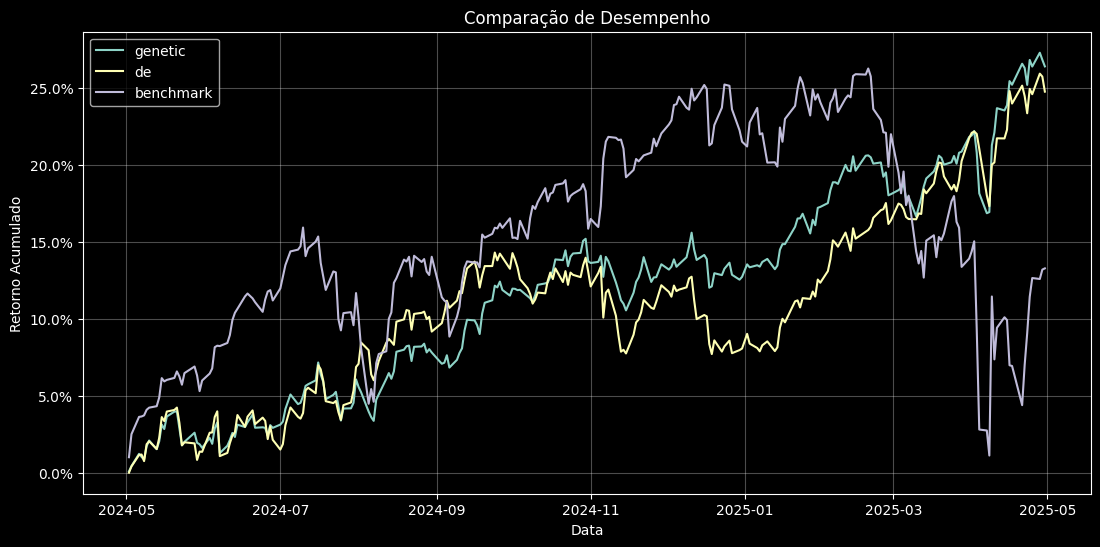

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [20]:
# Compara desempenho dos portfólios
cumulative_returns, metrics = compare_portfolio_performance(
    df_returns, weights, benchmark_returns
)

# Plota comparação de desempenho
fig, ax = plot_performance_comparison(cumulative_returns)
plt.show()

In [21]:
# Exibe métricas de desempenho
print("\nMétricas de desempenho:")
for optimizer, metric in metrics.items():
    print(f"{optimizer.capitalize()}: Retorno Acumulado={metric['cumulative_return']:.4f}, "
          f"Sharpe={metric['sharpe_ratio']:.4f}, Sortino={metric['sortino_ratio']:.4f}, "
          f"Max Drawdown={metric['max_drawdown']:.4f}")


Métricas de desempenho:
Genetic: Retorno Acumulado=0.2638, Sharpe=2.5572, Sortino=3.8048, Max Drawdown=-0.0436
De: Retorno Acumulado=0.2474, Sharpe=2.0908, Sortino=3.0058, Max Drawdown=-0.0576
Benchmark: Retorno Acumulado=0.1327, Sharpe=0.6450, Sortino=0.8018, Max Drawdown=-0.1989


### Simulação de 1000 portfólios com pesos aleatórios

In [22]:
import pandas as pd
def simulate_random_portfolios_VaR(num_portfolios,df):
    results_matrix = np.zeros((len(df.columns)+3, num_portfolios))
    for i in range(num_portfolios):
        non_zeros = np.random.random(OPTIMIZATION_PARAMS['nr_assets'])
        zeros = np.zeros(len(df.columns)- OPTIMIZATION_PARAMS['nr_assets'])
           # Combinar os dois arrays
        combined_array = np.concatenate((zeros, non_zeros))
        # Embaralhar o array combinado
        np.random.shuffle(combined_array)
        weights =combined_array/ np.sum(combined_array)
        portfolio_return, portfolio_std, portfolio_VaR = genetic_optimizer.calc_portfolio_perf_VaR(weights, df, OPTIMIZATION_PARAMS['days'])
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]

    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])

    return results_df

In [23]:
num_portfolios = 1000
results_frame = simulate_random_portfolios_VaR(num_portfolios, df_returns)

No gráfico abaixo podemos verificar o ponto azul que é o ponto de menor valor Retono x Var gerado a partir dos pesos aleatórios. O ponto em vermelho foi gerado através do modelo de otimização e mostra a maximização do retorno para uma faixa de VaR atribuída.

/tmp/ipython-input-1033779421.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='b',s=100)


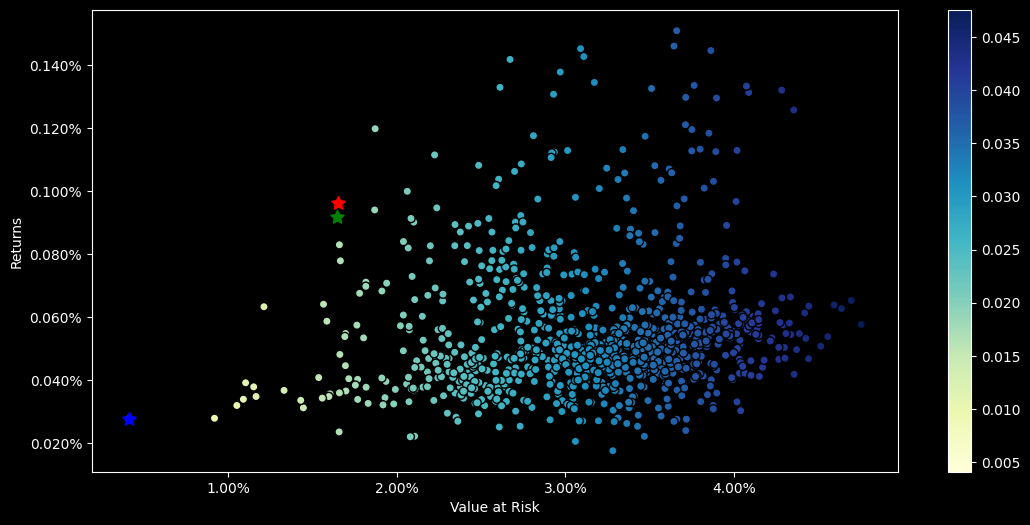

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [24]:
import matplotlib.ticker as mtick
#locate position of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
fig, ax = plt.subplots(figsize=(13,6))
plt.scatter(results_frame.VaR,results_frame.ret,c=results_frame.VaR,edgecolors="black",cmap='YlGnBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()

# Formatar o eixo x como percentual
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# Formatar o eixo y como percentual
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
#plot blue star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='b',s=100)
plt.scatter(genetic_result[2],genetic_result[0],marker=(5,1,0),color='r',s=100)
plt.scatter(de_result[2],de_result[0],marker=(5,1,0),color='g',s=100)
plt.show()

### Definição de um benchark

Foi definido um benchmark (S&P 100) para comparação do desempenho do portfolio

### Comparação dos resultados do portfolio gerado com o benchmark

O sharpe gerado pelo portifolio foi maior do que o gerado pelo benckmark

## Estudo para implementação de ferramenta de geração de portfolios

In [25]:
try:
    print(f"Baixando dados históricos de {DATA_PARAMS['start_date']} a {DATA_PARAMS['end_date']}...")
    df = download_price_data(
        tickers,
        DATA_PARAMS['test_start_date'],
        DATA_PARAMS['test_end_date']
    )

    # Baixa benchmark
    benchmark_df = download_price_data(
        DATA_PARAMS['benchmark'],
        DATA_PARAMS['test_start_date'],
        DATA_PARAMS['test_end_date']
    )

    # Pré-processa dados
    df_returns = preprocess_price_data(df)
    benchmark_returns = preprocess_price_data(benchmark_df).iloc[:, 0]

    print(f"Dados processados: {df_returns.shape[0]} observações, {df_returns.shape[1]} ativos")
except Exception as e:
    print(f"Erro ao baixar dados: {e}")
    raise


/tmp/ipython-input-2915766330.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start_date, end=end_date)[column]
[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[                       0%                       ]sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7b2a607c6510>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7b2a607c66d0>
[***                    6%                       ]  3 of 50 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a fu

Baixando dados históricos de 2024-05-01 a 2025-05-01...
Baixando dados para 50 tickers de 2024-05-01 a 2025-05-01


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7b2a607c6eb0>
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[**********            20%                       ]  10 of 50 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects t

Baixando dados para 4 tickers de 2024-05-01 a 2025-05-01


[*********************100%***********************]  1 of 1 completed

Dados processados: 249 observações, 50 ativos


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [26]:
def create_subseries(df, n_train, m_test):
    """
    Cria subseries para backtesting.

    Args:
        df (pandas.DataFrame): DataFrame com retornos diários.
        n_train (int): Número de meses para treinamento.
        m_test (int): Número de meses para teste.

    Returns:
        list: Lista de tuplas (treino, teste).
    """
    if isinstance(df, pd.Series):
        df = df.to_frame()

    # Extrair o mês e o ano
    df = df.copy()
    df['ano_mes'] = df.index.to_period('M')

    # Agrupar por ano e mês
    grouped = df.groupby('ano_mes')

    # Criar a lista de subseries
    subseries = [group.drop('ano_mes', axis=1) for _, group in grouped]

    splited_subseries = []
    for i in range(len(subseries) - n_train - m_test + 1):
        splited_subseries.append((
            pd.concat(subseries[i:n_train+i]),
            pd.concat(subseries[i+n_train:i+n_train+m_test])
        ))

    return splited_subseries


In [33]:
def run_backtest(optimizer_class, df_rets, benchmark_rets, n_train, m_test, optimization_params=None, optimizer_params=None):
    """
    Executa backtesting para um otimizador.

    Args:
        optimizer_class (class): Classe do otimizador
        df_rets (pandas.DataFrame): DataFrame com retornos diários dos ativos
        benchmark_rets (pandas.Series): Série com retornos diários do benchmark
        n_train (int): Número de meses para treinamento
        m_test (int): Número de meses para teste
        optimization_params (dict, optional): Parâmetros para otimização
        optimizer_params (dict, optional): Parâmetros específicos do otimizador

    Returns:
        pandas.DataFrame: DataFrame com resultados do backtesting
    """
    # Parâmetros padrão se não fornecidos
    if optimization_params is None:
        optimization_params = {
            'alpha': 0.95,
            'days': 1,
            'lbda': 0.94,
            'nr_assets': 5,
            'vl_var_min': 0.016,
            'vl_var_max': 0.017,
            'min_weight': 0.05
        }

    if optimizer_params is None:
        if optimizer_class.__name__ == 'GeneticOptimizer':
            optimizer_params = {
                'population_size': 1500,
                'generations': 20,
                'crossover_prob': 0.85,
                'mutation_prob': 0.5,
                'tournament_size': 10,
                'indpb': 0.3
            }
        elif optimizer_class.__name__ == 'PSOOptimizer':
            optimizer_params = {
                'n_particles': 100,
                'n_iterations': 50,
                'c1': 1.5,
                'c2': 1.5,
                'w': 0.7,
                'k': 3,
                'p': 2
            }
        elif optimizer_class.__name__ == 'DEOptimizer':
            optimizer_params = {
                'population_size': 100,
                'max_iter': 50,
                'F': 0.5,
                'CR': 0.7,
                'strategy': 'best1bin'
            }

    # Cria subseries para backtesting
    data_test = create_subseries(df_rets, n_train, m_test)
    data_bench_test = create_subseries(benchmark_rets, n_train, m_test)

    results = []

    for i in range(len(data_test)):
        print(f"Período {i+1}/{len(data_test)}")

        # Cria otimizador
        optimizer = optimizer_class(
            optimization_params['alpha'],
            optimization_params['days'],
            optimization_params['lbda'],
            optimization_params['nr_assets'],
            optimization_params['vl_var_min'],
            optimization_params['vl_var_max'],
            optimization_params['min_weight']
        )

        # Define retornos para o período atual
        optimizer.set_returns(data_test[i][0])

        # Executa otimização
        weights = optimizer.optimize(**optimizer_params, verbose=False)

        # Avalia desempenho no conjunto de treino
        train_result = optimizer.calc_portfolio_perf_VaR(weights, data_test[i][0], optimization_params['days'])
        train_sharpe = train_result[0] / train_result[1]

        # Avalia desempenho do benchmark no conjunto de treino
        bench_train_result = optimizer.calc_portfolio_perf_VaR(
            np.array([1.0]), data_bench_test[i][0], optimization_params['days']
        )
        bench_train_sharpe = bench_train_result[0] / bench_train_result[1]

        # Avalia desempenho no conjunto de teste
        test_result = optimizer.calc_portfolio_perf_VaR(weights, data_test[i][1], optimization_params['days'])
        test_sharpe = test_result[0] / test_result[1]

        # Avalia desempenho do benchmark no conjunto de teste
        bench_test_result = optimizer.calc_portfolio_perf_VaR(
            np.array([1.0]), data_bench_test[i][1], optimization_params['days']
        )
        bench_test_sharpe = bench_test_result[0] / bench_test_result[1]

        # Armazena resultados
        results.append({
            'period': i,
            'weights': weights,
            'train_vol_port': train_result[1],
            'train_vol_bench': bench_train_result[1],
            'train_ret_port': train_result[0],
            'train_ret_bench': bench_train_result[0],
            'train_var_port': train_result[2],
            'train_var_bench': bench_train_result[2],
            'train_sharpe_port': train_sharpe,
            'train_sharpe_bench': bench_train_sharpe,
            'test_vol_port': test_result[1],
            'test_vol_bench': bench_test_result[1],
            'test_ret_port': test_result[0],
            'test_ret_bench': bench_test_result[0],
            'test_var_port': test_result[2],
            'test_var_bench': bench_test_result[2],
            'test_sharpe_port': test_sharpe,
            'test_sharpe_bench': bench_test_sharpe
        })

        print(f"Período {i+1}: Sharpe treino={train_sharpe:.4f}, Sharpe teste={test_sharpe:.4f}")

    return pd.DataFrame(results)

In [34]:
results = run_backtest(GeneticOptimizer, df_returns, benchmark_returns, 6, 1,OPTIMIZATION_PARAMS)

Período 1/6
Inicializado otimizador com alpha=0.95, days=1, lambda=0.94, nr_assets=5, var_min=0.016, var_max=0.017, min_weight=0.05
Inicializado otimizador genético
Definidos retornos com 127 observações e 50 ativos
Iniciando otimização genética com população=1500, gerações=20


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3210093248.py:210: RuntimeWarning: invalid value encountered in divide
  weights = weights / np.sum(weights)


Otimização concluída. Melhor fitness: 0.001393009375507388
Período 1: Sharpe treino=0.1493, Sharpe teste=0.4557
Período 2/6
Inicializado otimizador com alpha=0.95, days=1, lambda=0.94, nr_assets=5, var_min=0.016, var_max=0.017, min_weight=0.05
Inicializado otimizador genético
Definidos retornos com 126 observações e 50 ativos
Iniciando otimização genética com população=1500, gerações=20
Otimização concluída. Melhor fitness: 0.0015904789458180643
Período 2: Sharpe treino=0.1705, Sharpe teste=-0.0799
Período 3/6
Inicializado otimizador com alpha=0.95, days=1, lambda=0.94, nr_assets=5, var_min=0.016, var_max=0.017, min_weight=0.05
Inicializado otimizador genético
Definidos retornos com 128 observações e 50 ativos
Iniciando otimização genética com população=1500, gerações=20
Otimização concluída. Melhor fitness: 0.00141575859393834
Período 3: Sharpe treino=0.1539, Sharpe teste=0.3593
Período 4/6
Inicializado otimizador com alpha=0.95, days=1, lambda=0.94, nr_assets=5, var_min=0.016, var_ma

In [35]:
results

,period,weights,train_vol_port,train_vol_bench,train_ret_port,train_ret_bench,train_var_port,train_var_bench,train_sharpe_port,train_sharpe_bench,test_vol_port,test_vol_bench,test_ret_port,test_ret_bench,test_var_port,test_var_bench,test_sharpe_port,test_sharpe_bench
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.3833736956347425, ...",0.009327,0.008213,0.001393,0.001200,0.016735,0.014709,0.149349,0.146123,0.007227,0.006923,0.003294,0.002631,0.015181,0.014019,0.455740,0.380073
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.3394407198776205, ...",0.009328,0.007675,0.001590,0.001161,0.016934,0.013785,0.170508,0.151323,0.009594,0.008835,-0.000766,-0.000164,0.015014,0.014369,-0.079886,-0.018546
2,2,"[0.0, 0.0, 0.0, 0.0, 0.24015912909537632, 0.0,...",0.009201,0.009373,0.001416,0.000741,0.016549,0.016158,0.153878,0.079004,0.007502,0.008369,0.002696,0.001092,0.015035,0.014858,0.359329,0.130486
3,3,"[0.0, 0.0, 0.0, 0.0, 0.200779312001018, 0.0, 0...",0.009250,0.009678,0.001490,0.000882,0.016704,0.016802,0.161075,0.091128,0.007456,0.009651,-0.001864,-0.000846,0.010401,0.015028,-0.249926,-0.087700
4,4,"[0.0, 0.0, 0.0, 0.0, 0.10818532139580882, 0.33...",0.009065,0.009807,0.001453,0.000588,0.016364,0.016719,0.160322,0.059975,0.009749,0.015622,0.001517,-0.003161,0.017552,0.022536,0.155587,-0.202316
5,5,"[0.0, 0.3276818783698136, 0.0, 0.0, 0.0, 0.278...",0.009160,0.012503,0.001138,-0.000134,0.016205,0.020432,0.124273,-0.010694,0.011689,0.023716,0.002660,0.000233,0.021886,0.039243,0.227579,0.009845


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [37]:
data_test = create_subseries(df_returns, 6, 1)
data_bench_test = create_subseries(benchmark_returns, 6, 1)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


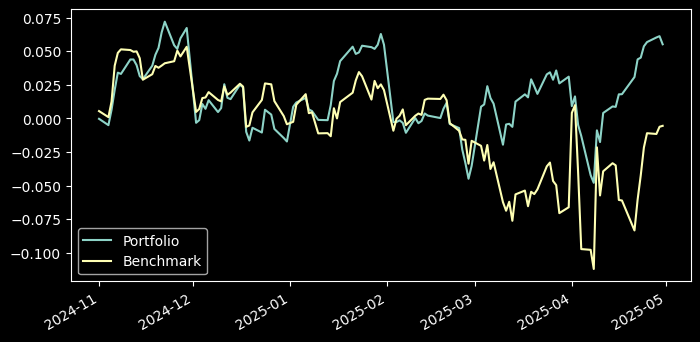

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [38]:
total_cumulative_returns = pd.DataFrame()
total_cumulative_returns_bench = pd.DataFrame()
for i in range(len(data_test)):
  # Calculate the weighted stock returns
  WeightedReturns = data_test[i][1]*results.loc[i,'weights']
  # Calculate the weighted stock returns
  portfolioReturns= WeightedReturns.sum(axis=1)
  # Plot the cumulative portfolio returns over time
  cumulative_returns = ((1+portfolioReturns).cumprod()-1)
  cumulative_returns_bench = ((1+data_bench_test[i][1]).cumprod()-1)
  total_cumulative_returns = pd.concat([total_cumulative_returns,cumulative_returns],axis=1)
  total_cumulative_returns_bench = pd.concat([total_cumulative_returns_bench,cumulative_returns_bench],axis=1)

df_perf_compare = pd.DataFrame({'Portfolio':total_cumulative_returns.mean(axis=1),'Benchmark':total_cumulative_returns_bench.mean(axis=1)})
df_perf_compare.plot(figsize=(8,4))
plt.show()

Comparação da rentabilidade acumulada do portfolio x benchmarck nos períodos de treino.

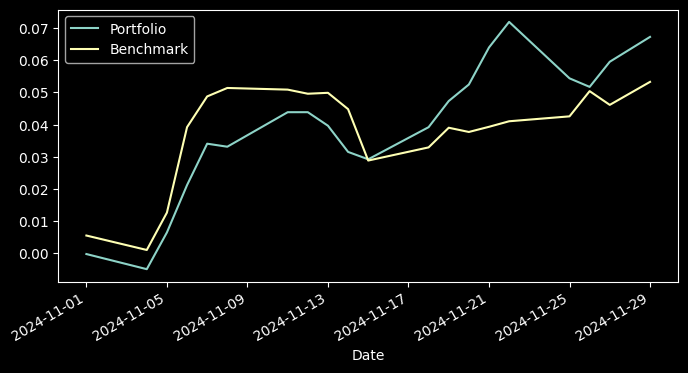

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


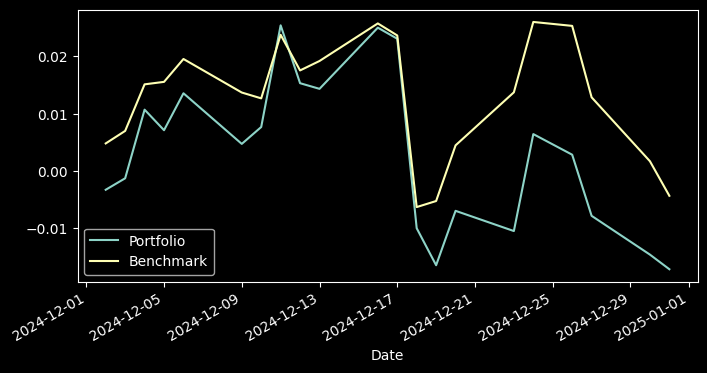

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


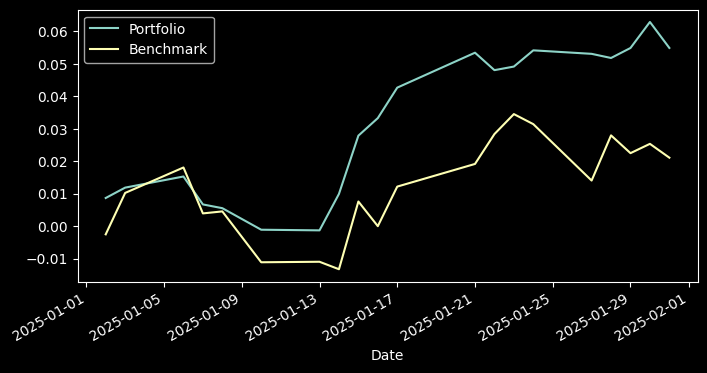

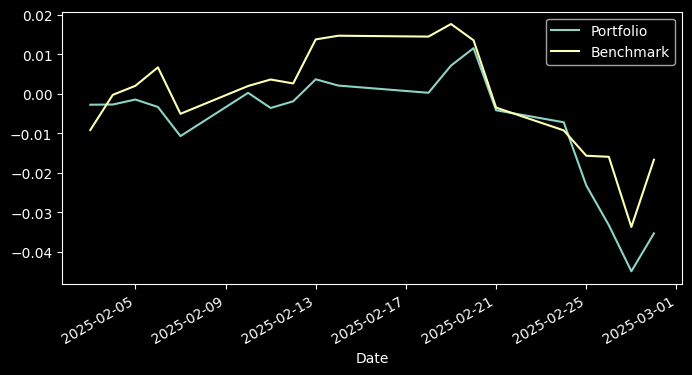

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


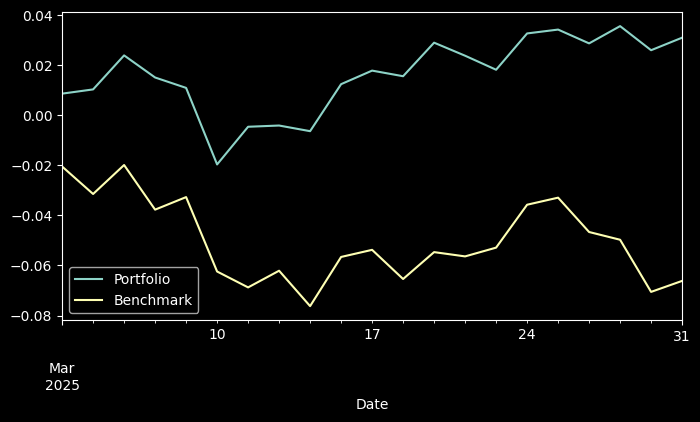

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


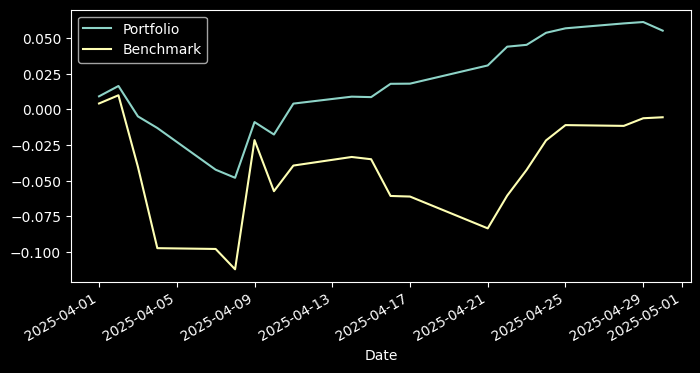

In [40]:
for i in range(len(data_test)):
  # Calculate the weighted stock returns
  WeightedReturns = data_test[i][1]*results.loc[i,'weights']
  # Calculate the weighted stock returns
  portfolioReturns= WeightedReturns.sum(axis=1)
  # Plot the cumulative portfolio returns over time
  CumulativeReturns = ((1+portfolioReturns).cumprod()-1)
  CumulativeReturnsBench = ((1+data_bench_test[i][1]).cumprod()-1)
  df_perf_compare = pd.DataFrame({'Portfolio':CumulativeReturns,'Benchmark':CumulativeReturnsBench.squeeze()})
  df_perf_compare.plot(figsize=(8,4))
  plt.show()

In [ ]:
results.to_json(f'/content/drive/My Drive/resultados_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json', orient='records', lines=True)